# Business Case

For this data science challenge, you are provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.

 

The goal of this data science challenge is twofold:

1. To calculate the potential for a yearly reduction in CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.

2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

3. (Bonus question) Identify clusters of taxi cabs that you find being relevant from the taxi cab company point of view.

# 0. IMPORTS & HELPER FUNCTIONS

## 0.1 Imports

In [1]:
import random
import datetime
from os import listdir
from os.path import join as jp

import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, degrees, sin, cos, asin, acos, sqrt
import tensorflow
from pandas_profiling import ProfileReport

from keras.models import Sequential
from keras.layers import Dense, Input, Activation, BatchNormalization, Dropout

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score,recall_score, f1_score, make_scorer, cohen_kappa_score, balanced_accuracy_score

pd.options.mode.chained_assignment = None

Using TensorFlow backend.


## 0.2 Helper Function

In [2]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

# 1. BUSINESS UNDERSTANDING, ASSUMPTIONS & APPROACHES
Firstly an in-depth analysis of the business objectives and needs has to be done. Current situation must be accessed and from these insights, the goals of carrying out the processes must be defined. This should follow the setting up of a plan to proceed. In our case, our aim is finding yearly CO2 emission reduction, predicting for taxi drivers, predicting the next place a passenger will hail a cab and Identify clusters of taxi cabs that you find being relevant.

## Case 1 - CO2 emission reduction

In order to find yearly CO2 emission reduction, 
* We need to find distance via longitude and latitude in Miles. 
* It should be in miles metric because in the question it is given by average passenger vehicle emits about 404 grams of CO2 per mile. 
* I use only 10% of .txt files. 
    * Within those files I kept only occupancy set to zero. Because in the question asked that by the taxi cabs roaming without passengers.
* I calculate the distances of all drivers to have the total distance of interest for one month. 
    * I multiply the result by 12 and get the yearly distance of interest for the CO2 emissions Then, I assume that the taxi cab fleet is changing at the rate of 15% per month. This policy means that the number of taxis with combustion engines is reduced by 15% every month. 
    * Accordingly I assume that the distance for CO2 emissions is also reduced by 15% every month. Applying this policy for 12 months gives me the new distance for the CO2 emissions with EVs.
* Then, I take the two distances, divide them by 0.1. Because I only took 10% of the files for my calculation and thus approximate the total distance of all taxis. 
* Finally, I get the CO2 reduction by multiplying the total distance with the number of CO2 grams per mile and comparing the difference in terms of percentage.

## Case 2 - Next place a passenger will hail a cab (Occupancy Model)
Based on on the given dataset with Lat, Lon, Time data, To predict the next place a passenger will hail a cab, I divided the question in to two phases. 
* First Phase - To predict the next place that cab will go. 
* Second Phase -  To predict occupancy - customer hail the cab.

* First Phase
    * We can think it as time series problem. I build a model that predict the location in t by using as previous location in t-1, t-2 and t-3. First I create simple neural network model with one input layer, one hidden layer and one output layer for one taxi driver.
    * Alternatively, I predict longitude and latitude separately with Gradient Boosting algorithm. In order to increase performance of GBM model, we can change the previous window and hyper-parameter tuning. 

* Second Phase
    * I build a Random Forest Classifier to predict whether next location is a pick-up point or not. 
    * I subset 10% of the total data and all data and using timestamp data I generate day of week, hour and time data. 
    * I think also adding holiday and weather data will be very useful to our model. 
    * So I added holiday data as a flag and retrain Random Forest Classifier model. T
        * There is only 1 holiday in the given period of time which are Memorial Day(26th of May). 
        * Result of Holiday Flag added model has 1% increase in F1 amd Precision of predicting hailing a cab. 
        * Therefore we can use holiday flag for our model and it gives other data such as weather will be valuable.

    * Note: I do not do hyper-parameter optimization because of the time/ resource constraint. Other algorithms logistic regression, SVM, XgBoost, light GBM etc. could have been used.

* Finding next pick-up point (Final Occupancy Model)
    * We can get the next pick-up location by combining the next location predictor for each taxi driver and the occupancy classifier.
    * The next location prediction coordinates can be fed into the pick-up point classifier which will indicate the next pick-up location with a certain probability.

## Case 3 - Bonus Question - Identify clusters of taxi cabs that you find being relevant.
I apply two different methods to identify cluster of taxi cabs.

First Approach:
* Using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) that is a popular unsupervised learning method utilized in model building and machine learning algorithms
    * I subset 10% of the total data and divided into two in terms of occupancy flag
    * I looked other cabs where they are driving in the past and where they will go after it
    * By doing so, I clustered its cabs together based on similarity of behavior

Second Approach
* Implementing RFM [Recency, Frequency, Monetary Value ] methodology
    * I subset 10% of the total data and I found total miles per cab, total occupied miles per cab and average active minutes per day
    * Using mindset of RFM, I split the data into 4 in terms of quantile
    * Using this quantiles, I create 7 sample of segments
    * I gave the definition of segments in the coding phase

# 2. DATA UNDERSTANDING
We have mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time]

## 2.1 Data Loading

In [3]:
import os 
os.getcwd()

'/home/jupyter/PMI'

In [4]:
# Randomly selecting 10% of the data
path = '/home/jupyter/PMI/cabspottingdata'

all_files = [file_name for file_name in listdir(path) if file_name.endswith('.txt')]
print(f'All files are {len(all_files)}')

PerofFiles = 0.1

random.Random(1923).shuffle(all_files)
SelectedFiles = all_files[:int(PerofFiles * len(all_files))]

print(f'\n{len(SelectedFiles)} randomly selected files')

All files are 537

53 randomly selected files


# 3. DATA PREPERATION

Most data used for data mining was originally collected and preserved for other purposes and needs some refinement before it is ready to use for modeling.

The data preparation phase includes five tasks. These are

Selecting data

Cleaning data

Constructing data

Integrating data

Formatting data

In [5]:
def ConverttoDF(file_name: str):
    df = pd.read_csv(jp(path, file_name), sep=' ', header=None)
    df.index = file_name.split('.')[0] + "_" + df.index.map(str)
    df.columns = ['Latitude', 'Longitude', 'Occupancy', 'Timestamp']
    df['Taxi'] = file_name.split('.')[0]
    return df

def PreviousCoordinates(df: DataFrame):
    df['PrevLatitude'] = df.shift(1)['Latitude']
    df['PrevLongitude'] = df.shift(1)['Longitude']
    df = df.dropna()
    return df

def EstimatedDistance(row: Series):
    # formulation of finding distance via longitude and latitude in Miles from
    # https://www.geeksforgeeks.org/program-distance-two-points-earth/
    Longitude = row['Longitude']
    Latitude = row['Latitude']
    PrevLongitude = row['PrevLongitude']
    PrevLatitude = row['PrevLatitude']
    Longitude, Latitude, PrevLongitude, PrevLatitude = map(radians, 
                                                                    [Longitude, Latitude, 
                                                                    PrevLongitude, PrevLatitude])
    try:
        return 3959 * (acos(sin(Latitude) * sin(PrevLatitude) + cos(Latitude) * cos(PrevLatitude) * 
                                cos(Longitude - PrevLongitude)))
    except:
        return 0.0

def DistanceCalculation(df: DataFrame):
    df['Miles'] = 0.0
    df['Miles'] = df.apply(lambda row: EstimatedDistance(row), axis=1)
    return df

Data = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    Data = pd.concat([Data, df])

In [6]:
Data.head()

Latitude  Longitude  Occupancy   Timestamp         Taxi  \
new_ictmuog_1  37.76981 -122.44865          1  1211018472  new_ictmuog   
new_ictmuog_2  37.76982 -122.44860          0  1211018474  new_ictmuog   
new_ictmuog_3  37.76985 -122.44846          0  1211018485  new_ictmuog   
new_ictmuog_4  37.77042 -122.44383          0  1211018542  new_ictmuog   
new_ictmuog_5  37.76965 -122.44238          0  1211018602  new_ictmuog   

               PrevLatitude  PrevLongitude     Miles  
new_ictmuog_1      37.76956     -122.45071  0.113836  
new_ictmuog_2      37.76981     -122.44865  0.002817  
new_ictmuog_3      37.76982     -122.44860  0.007923  
new_ictmuog_4      37.76985     -122.44846  0.255939  
new_ictmuog_5      37.77042     -122.44383  0.095411

## 3.1 Data Dimension

In [7]:
print('Number of Rows: {}'.format(Data.shape[0]))
print('Number of Cols: {}'.format(Data.shape[1]))

Number of Rows: 1082473
Number of Cols: 8


## 3.2 Data Types and Structure

In [8]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082473 entries, new_ictmuog_1 to new_afpansh_24357
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Latitude       1082473 non-null  float64
 1   Longitude      1082473 non-null  float64
 2   Occupancy      1082473 non-null  int64  
 3   Timestamp      1082473 non-null  int64  
 4   Taxi           1082473 non-null  object 
 5   PrevLatitude   1082473 non-null  float64
 6   PrevLongitude  1082473 non-null  float64
 7   Miles          1082473 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 74.3+ MB


## 3.3 Missing Values Check

In [9]:
# Checking for percentage of missing values in each column
percent_missing = Data.isnull().sum() * 100 / len(Data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

percent_missing
Latitude                   0.0
Longitude                  0.0
Occupancy                  0.0
Timestamp                  0.0
Taxi                       0.0
PrevLatitude               0.0
PrevLongitude              0.0
Miles                      0.0

There are no missing values

# 4. EXPLORATORY DATA ANALYSIS

## 4.1 Descriptive Stats

In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
Data.describe()

Latitude  Longitude  Occupancy     Timestamp  PrevLatitude  \
count 1082473.00 1082473.00 1082473.00    1082473.00    1082473.00   
mean       37.76    -122.41       0.45 1212024053.83         37.76   
std         0.06       0.04       0.50     583824.66          0.06   
min        34.66    -126.61       0.00 1211018413.00         34.66   
25%        37.75    -122.42       0.00 1211517098.00         37.75   
50%        37.78    -122.41       0.00 1212029311.00         37.78   
75%        37.79    -122.40       1.00 1212529616.00         37.79   
max        50.31    -122.00       1.00 1213089596.00         50.31   

       PrevLongitude      Miles  
count     1082473.00 1082473.00  
mean         -122.41       0.25  
std             0.04       1.88  
min          -126.61       0.00  
25%          -122.42       0.02  
50%          -122.41       0.15  
75%          -122.40       0.29  
max          -122.00     866.62

Distribution of Occupancy and Vacancy

In [88]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,2)
sns.distplot(Data['Occupancy'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Occupancy', ylabel='Density'>

By inspecting the data, I found that some coordinates are places in the Pacific ocean but we assume that this is a GPS error.

Maximum time is Jun 10 2008 11:19:56 GMT+0200 (Central European Summer Time) and minimum time is May 17 2008 12:00:13 GMT+0200 (Central European Summer Time)

Occupancy and vacancy rate seems to be equally distributed.

## 4.2 All Variable Stats - Distribution , Cardinality, Correlation
* Capturing Complete Stats of All features
    * Distribution of data across each feature
    * Cardinality Check
    * Correlation between Numerical Features using Pearson's , Spearman's, Kendall's correlation

In [16]:
profile = ProfileReport(Data, minimal=False)
profile.to_file(output_file="CabSpotting_EDA.html")

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
profile

# 5. MODELLING
After data preparation, our data is already in good shape, and now you can search for useful patterns in your data. The modeling phase includes four tasks. These are

Selecting modeling techniques

Designing test(s)

Building model(s)

Assessing model(s)

## 5.1 Case 1: CO2 Reduction Analysis

Average vacant distance for each taxi driver who have been selected

In [10]:
NoPassenger = Data[Data['Occupancy'] == 0]
#Distance Without Passanger
DistanceWOPassenger = NoPassenger.groupby(by=['Taxi'])['Miles'].sum()
print(DistanceWOPassenger)

Taxi
new_abniar      2590.842111
new_afpansh     2479.908231
new_agcowktu    2918.599387
new_aimidd      2194.684701
new_akyeerbi    2559.321762
new_asigno      2801.320631
new_aucjun       575.353038
new_awribig     1795.936970
new_aygpha      1644.288618
new_ecfesy      2358.376125
new_ecjeody     2504.602062
new_ecnoplsi    2186.223883
new_ednillo     2881.372471
new_edrafs       482.309353
new_eifvid      2062.368986
new_eincufpy     410.543981
new_ejshigib    2942.368152
new_ekyosjo     2589.396804
new_eoccoirv    3179.457237
new_eotcue         3.442394
new_epabcadu    2858.633472
new_equioc      2952.193538
new_etalrab     3465.283417
new_eybyay      3067.374287
new_eydadgio     322.805575
new_iblool      1801.761964
new_ictmuog      647.185208
new_ifefrof     2055.136048
new_ijprukfr    2655.647614
new_imwrytsy    2438.926104
new_imwyojy     2208.934694
new_inckkiv     2538.402219
new_ioytgor     2396.929335
new_ishvirv     2486.837255
new_itacfl      3053.725553
new_oapwycti   

In [11]:
DistanceWOPassengerPerMonth = DistanceWOPassenger.sum()
#We can assume that multiplying monthly distance by 12, we can find the yearly distance.
DistanceWOPassengerPerYear = DistanceWOPassengerPerMonth * 12

print(f'The distance for CO2 in one year (combustion engine-powered vehicles) '
      f'is approx {round(DistanceWOPassengerPerYear)} Miles\n')


#electric vehicles
DistanceWOPassengerPerYearEV = 0.0


#assume that the taxi cab fleet is changing at the rate of 15% per month
for month in range(12):
    if month == 0:
        DistanceWOPassengerPerMonthEV = DistanceWOPassengerPerMonth
        DistanceWOPassengerPerYearEV = DistanceWOPassengerPerMonth
    else:
        DistanceWOPassengerPerMonthEV = DistanceWOPassengerPerMonthEV * 0.15
        DistanceWOPassengerPerYearEV += DistanceWOPassengerPerMonthEV
    print(f'The distance for CO2 after {month} month(s) of'
          f' Electric Vehicles is approx {round(DistanceWOPassengerPerMonthEV, 3)} Miles')
    
print(f'\nThe distance for CO2 after one year of Electric Vehicles '
      f' is approx {round(DistanceWOPassengerPerYearEV)} Miles')

The distance for CO2 in one year (combustion engine-powered vehicles) is approx 1451484 Miles

The distance for CO2 after 0 month(s) of Electric Vehicles is approx 120957.039 Miles
The distance for CO2 after 1 month(s) of Electric Vehicles is approx 18143.556 Miles
The distance for CO2 after 2 month(s) of Electric Vehicles is approx 2721.533 Miles
The distance for CO2 after 3 month(s) of Electric Vehicles is approx 408.23 Miles
The distance for CO2 after 4 month(s) of Electric Vehicles is approx 61.235 Miles
The distance for CO2 after 5 month(s) of Electric Vehicles is approx 9.185 Miles
The distance for CO2 after 6 month(s) of Electric Vehicles is approx 1.378 Miles
The distance for CO2 after 7 month(s) of Electric Vehicles is approx 0.207 Miles
The distance for CO2 after 8 month(s) of Electric Vehicles is approx 0.031 Miles
The distance for CO2 after 9 month(s) of Electric Vehicles is approx 0.005 Miles
The distance for CO2 after 10 month(s) of Electric Vehicles is approx 0.001 Miles

In [12]:
CO2GramsPerMiles = 404

#CO2 emissions without electric vehicles

CO2EmissionWOEV = DistanceWOPassengerPerYear / PerofFiles * CO2GramsPerMiles

#CO2 emissions with electric vehicles

CO2EmissionWEV = DistanceWOPassengerPerYearEV / PerofFiles * CO2GramsPerMiles

CO2Reduction = round((CO2EmissionWOEV - CO2EmissionWEV) / CO2EmissionWOEV, 4)

print(f'The CO2 emissions are reduced by {CO2Reduction * 100} %')

The CO2 emissions are reduced by 90.2 %


## 5.2 Case 2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

### 5.2.1 Case 2 - Phase 1 - Predicting Next Place [For Single Taxi Driver]

In [14]:
#San Francisco coordinate is 37.7749° N, 122.4194° W. 
#Therefore we can use 37 and 122 as offset value in order to normalized our data

lat_offset = 37.0
long_offset = -122.0
taxi_driver = SelectedFiles[0]

datapoints = []
with open(file=jp(path, taxi_driver), mode='r') as f:
    for line in f:
        lat, long, occ, ts = line.split()
        datapoints.append([float(lat) - lat_offset, float(long) - long_offset])

In [15]:
TaxiDrivers = SelectedFiles[0]

Data = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Latitude, Longitute, Occupation, TS = line.split()
        Data.append([Latitude, Longitute])

In order to create a new dataset as a timeseries mindset, I follow below steps

In [16]:
X = []
Y = []
timeseries = 3
for x in range(len(Data) - timeseries):
    TimeSteps = Data[x:x + timeseries]
    X.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    Y.append(Data[x + timeseries])

This is a timeseries approach so splitting train and test data should be first n% as train last (1-n) % as test. I select 80-20 split rule.

In [17]:
TraingTestSize = round(len(X) * 0.8)

X_train = np.array(X[:TraingTestSize])
X_test = np.array(X[TraingTestSize:])

Y_train = np.array(Y[:TraingTestSize])
Y_test = np.array(Y[TraingTestSize:])

#### 5.2.1.1 Model 1 : Dense Neural Network
Here, I create neural network with one input layer, one hidden layer and one output layer. 

I follow MSE because this is a regression problem.

In [20]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(6,)))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='Adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [21]:
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), verbose=1)
print(f'MSE on training set {history.history["loss"][-1]}')
print(f'MSE on testing set {history.history["val_loss"][-1]}')

2022-01-04 21:46:00.717053: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2022-01-04 21:46:00.717584: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55dfabc13070 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-04 21:46:00.717620: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-04 21:46:00.718906: I tensorflow/core/common_runtime/process_util.cc:136] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Train on 7461 samples, validate on 1865 samples
Epoch 1/50
7461/7461 [==============================] - 3s 336us/step - loss: 8145.2446 - val_loss: 7938.9740
Epoch 2/50
7461/7461 [==============================] - 1s 126us/step - loss: 7914.4177 - val_loss: 7596.8816
Epoch 3/50
7461/7461 [==============================] - 1s 122us/step - loss: 7524.2920 - val_loss: 7212.5228
Epoch 4/50
7461/7461 [==============================] - 1s 122us/step - loss: 7003.7907 - val_loss: 6703.7109
Epoch 5/50
7461/7461 [==============================] - 1s 124us/step - loss: 6389.1535 - val_loss: 6056.8147
Epoch 6/50
7461/7461 [==============================] - 1s 126us/step - loss: 5717.2984 - val_loss: 5368.3829
Epoch 7/50
7461/7461 [==============================] - 1s 125us/step - loss: 5022.5606 - val_loss: 4672.6842
Epoch 8/50
7461/7461 [==============================] - 1s 126us/step - loss: 4334.8494 - val_loss: 3997.1137
Epoch 9/50
7461/7461 [==============================] - 1s 122us/step -

The neural network is trained for 50 epoches. Bellow, the training and testing losses are plotted. From the graph, we see that the network does not overfit. I exclude MSE of the first 15 epochs. Therefore, the MSE is already small and the difference between the train and test curve is visible. Otherwise, the loss at the first 15 epochs of the training is high and the two curves cannot be readable.

In [22]:
_, ax = plt.subplots()
ax.plot(history.history['loss'][15:])
ax.plot(history.history['val_loss'][15:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
ax.set_xticklabels(np.arange(5, 55, 5))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


In [23]:
Y_pred = model.predict(X_test)

In [24]:
Y_pred

array([[  37.766106, -122.42785 ],
       [  37.765728, -122.42663 ],
       [  37.76552 , -122.42577 ],
       ...,
       [  37.761322, -122.40917 ],
       [  37.761284, -122.40928 ],
       [  37.761284, -122.409294]], dtype=float32)

#### 5.2.1.2 Model 2 : Gradient Boosting Regressor

In this model I try to predict Latitude and Longitude seperately. After predict the next Latitude and Longitude we can predict next coordinates. I use Gradient Boosting Modelling techniques.

In order to understand the Gradient Boosting, first we have to understand what is boosting.

Boosting: It is an approach where you take random samples of data, however the selection of sample is made more intelligently. We subsequently give more and more weight to hard to classify observations.

So Gradient Boosting basically combines weak learners into a single strong learner in an iterative fashion

#### 5.2.1.2 (A) Predicting Latitude

In [25]:
TaxiDrivers = SelectedFiles[0]

DataLat = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Latitude, Longitute, Occupation, TS = line.split()
        DataLat.append([Latitude])

In [26]:
XLat = []
YLat = []
timeseries = 3
for x in range(len(DataLat) - timeseries):
    TimeSteps = DataLat[x:x + timeseries]
    XLat.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    YLat.append(DataLat[x + timeseries])

In [27]:
TraingTestSize = round(len(X) * 0.8)

XLat_train = np.array(XLat[:TraingTestSize])
XLat_test = np.array(XLat[TraingTestSize:])

YLat_train = np.array(YLat[:TraingTestSize])
YLat_test = np.array(YLat[TraingTestSize:])

import numpy as np
XLat_train=XLat_train.astype(np.float)
XLat_test=XLat_test.astype(np.float)
YLat_train=YLat_train.astype(np.float)
YLat_test=YLat_test.astype(np.float)

In [28]:
XLat_train

array([[37.76956, 37.76981, 37.76982],
       [37.76981, 37.76982, 37.76985],
       [37.76982, 37.76985, 37.77042],
       ...,
       [37.74981, 37.74888, 37.74835],
       [37.74888, 37.74835, 37.74826],
       [37.74835, 37.74826, 37.74851]])

In [29]:
YLat_train

array([[37.76985],
       [37.77042],
       [37.76965],
       ...,
       [37.74826],
       [37.74851],
       [37.75185]])

In [30]:
gbmregressor=GradientBoostingRegressor(n_estimators=100) 
model_gbm_Lat=gbmregressor.fit(XLat_train, YLat_train) 
pred_gbm_Lat=model_gbm_Lat.predict(XLat_test) 
pred_gbm_Lat

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([37.75299036, 37.75637549, 37.75568212, ..., 37.77211523,
       37.77211523, 37.77211523])

#### 5.2.1.2 (A) - i. Latitude Model Evaluation

In [31]:
YLat_test_2=YLat_test.reshape(-1)

In [32]:
actual_Lat=pd.Series(YLat_test_2)
pred_Lat=pd.Series(pred_gbm_Lat).reset_index()
result_Lat=pd.concat([actual_Lat,pred_Lat],axis=1)

In [33]:
result_Lat.set_index("index",inplace=True)
result_Lat.index.name=None
result_Lat.columns = ['actual_Lat', 'pred_Lat']
result_Lat

actual_Lat  pred_Lat
0          37.75     37.75
1          37.75     37.76
2          37.76     37.76
3          37.76     37.76
4          37.76     37.76
...          ...       ...
1860       37.77     37.78
1861       37.77     37.77
1862       37.77     37.77
1863       37.77     37.77
1864       37.77     37.77

[1865 rows x 2 columns]

In [34]:
error_Lat=result_Lat.actual_Lat-result_Lat.pred_Lat

R2_Lat=np.corrcoef(result_Lat.actual_Lat,result_Lat.pred_Lat)
MSE_Lat=(error_Lat**2).mean()
RMSE_Lat=(np.sqrt(MSE_Lat)).mean()
MAE_Lat=(np.abs(error_Lat)).mean()
MAPE_Lat=(np.abs(error_Lat)/result_Lat.actual_Lat).mean()

In [35]:
R2_Lat, MSE_Lat, RMSE_Lat, MAE_Lat, MAPE_Lat

(array([[1.        , 0.99127087],
        [0.99127087, 1.        ]]),
 2.2250297023191062e-05,
 0.004717022050318512,
 0.0018297825805430824,
 4.8476501240036925e-05)

#### 5.2.1.2 (B) Predicting Longitude

In [36]:
TaxiDrivers = SelectedFiles[0]

DataLon = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Latitude, Longitute, Occupation, TS = line.split()
        DataLon.append([Longitute])

In [37]:
XLon = []
YLon = []
timeseries = 3
for x in range(len(DataLon) - timeseries):
    TimeSteps = DataLon[x:x + timeseries]
    XLon.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    YLon.append(DataLon[x + timeseries])

In [38]:
TraingTestSize = round(len(X) * 0.8)

XLon_train = np.array(XLon[:TraingTestSize])
XLon_test = np.array(XLon[TraingTestSize:])

YLon_train = np.array(YLon[:TraingTestSize])
YLon_test = np.array(YLon[TraingTestSize:])

import numpy as np
XLon_train=XLon_train.astype(np.float)
XLon_test=XLon_test.astype(np.float)
YLon_train=YLon_train.astype(np.float)
YLon_test=YLon_test.astype(np.float)

In [39]:
gbmregressor=GradientBoostingRegressor(n_estimators=100) 
model_gbm_Lon=gbmregressor.fit(XLon_train, YLon_train) 
pred_gbm_Lon=model_gbm_Lon.predict(XLon_test) 
pred_gbm_Lon

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-122.42110603, -122.42097782, -122.41758856, ..., -122.40935618,
       -122.4087062 , -122.4087062 ])

#### 5.2.1.2 (B) - i. Longitude Model Evaluations

In [40]:
YLon_test_2=YLon_test.reshape(-1)

In [41]:
actual_Lon=pd.Series(YLon_test_2)
pred_Lon=pd.Series(pred_gbm_Lon).reset_index()
result_Lon=pd.concat([actual_Lon,pred_Lon],axis=1)

In [42]:
result_Lon.set_index("index",inplace=True)
result_Lon.index.name=None
result_Lon.columns = ['actual_Lon', 'pred_Lon']
result_Lon

actual_Lon  pred_Lon
0        -122.42   -122.42
1        -122.42   -122.42
2        -122.42   -122.42
3        -122.42   -122.42
4        -122.42   -122.42
...          ...       ...
1860     -122.41   -122.40
1861     -122.41   -122.41
1862     -122.41   -122.41
1863     -122.41   -122.41
1864     -122.41   -122.41

[1865 rows x 2 columns]

In [43]:
error_Lon=result_Lon.actual_Lon-result_Lon.pred_Lon

R2_Lon=np.corrcoef(result_Lon.actual_Lon,result_Lon.pred_Lon)
MSE_Lon=(error_Lon**2).mean()
RMSE_Lon=(np.sqrt(MSE_Lon)).mean()
MAE_Lon=(np.abs(error_Lon)).mean()
MAPE_Lon=(np.abs(error_Lon)/result_Lon.actual_Lon).mean()

In [44]:
R2_Lon, MSE_Lon, RMSE_Lon, MAE_Lon, MAPE_Lon

(array([[1.        , 0.98640084],
        [0.98640084, 1.        ]]),
 1.10444911959458e-05,
 0.0033233253220149544,
 0.0020437179908764295,
 -1.6694314029163133e-05)

In [45]:
Y_test_Final = np.concatenate([YLat_test, YLon_test], axis=1)

In [46]:
Pred_Final = np.concatenate([pred_gbm_Lat.reshape(-1,1), pred_gbm_Lon.reshape(-1,1)], axis=1)

In [47]:
Pred_Final

array([[  37.75299036, -122.42110603],
       [  37.75637549, -122.42097782],
       [  37.75568212, -122.41758856],
       ...,
       [  37.77211523, -122.40935618],
       [  37.77211523, -122.4087062 ],
       [  37.77211523, -122.4087062 ]])

#### 5.2.1.3 Case 2 - Phase 1 - Model Evaluation (NN and GBM Models)

You’ll evaluate not just the models you create but also the process that you used to create them, and their potential for practical use.

The evaluation phase includes three tasks. These are;

Evaluating results

Reviewing the process

Determining the next steps

In [48]:
plt.figure(figsize=(20, 20))
plt.subplot(421)
plt.scatter(pd.to_numeric(Y_test[:,0]) + lat_offset, pd.to_numeric(Y_test[:,-1]) + long_offset)
plt.title('NN True trajectory for {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
 
plt.subplot(422)
plt.scatter(pd.to_numeric(Y_pred[:,0]) + lat_offset, pd.to_numeric(Y_pred[:,-1]) + long_offset)
plt.title('NN Predicted trajectory {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
 

plt.subplot(423)
#plt.scatter(pd.to_numeric(pred_gbm_Lat[:,0]) + lat_offset, pd.to_numeric(pred_gbm_Lat[:,-1]) + long_offset)
plt.scatter(Pred_Final[:,0] + lat_offset, Pred_Final[:,-1] + long_offset)
plt.title('GBM True trajectory {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Latitude')
plt.xlabel('Longitude')
 
 

plt.subplot(424)
#plt.scatter(pd.to_numeric(pred_gbm_Lat[:,0]) + lat_offset, pd.to_numeric(pred_gbm_Lat[:,-1]) + long_offset)
plt.scatter(Pred_Final[:,0] + lat_offset, Pred_Final[:,-1] + long_offset)
plt.title('GBM Predicted trajectory {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.tight_layout()

In [49]:
TaxiDrivers = SelectedFiles[0]

Time = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Latitude, Longitute, Occupation, TS = line.split()
        Time.append([TS])

In [50]:
XTime = []
YTime = []
timeseries = 3
for x in range(len(Time) - timeseries):
    TimeSteps = Time[x:x + timeseries]
    XTime.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    YTime.append(Time[x + timeseries])

In [51]:
TraingTestSize = round(len(X) * 0.8)

YTime_test = np.array(YTime[TraingTestSize:])

import numpy as np
YTime_test=YTime_test.astype(np.float)

I also plot in the y-axis as a first dimension is Latitude, as a secondary dimension is Longitude. In the x-axis, I add time. Therefore, we can follow minutes by minutes latitude and longitude change. As a result, prediction looks good!

Text(0, 0.5, 'Longitude')

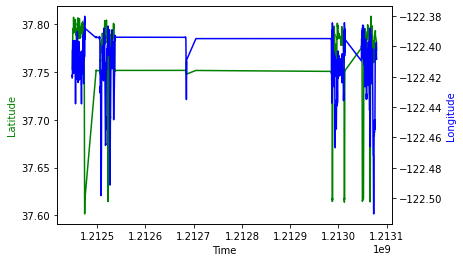

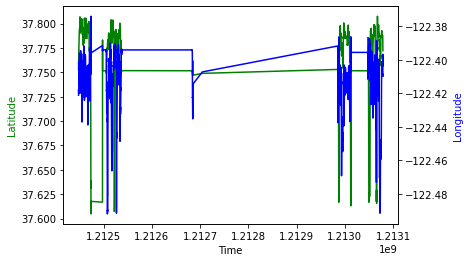

In [52]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(YTime_test, YLat_test, 'g-')
ax2.plot(YTime_test, YLon_test, 'b-')

ax1.set_xlabel('Time')
ax1.set_ylabel('Latitude', color='g')
ax2.set_ylabel('Longitude', color='b')

fig1, ax3 = plt.subplots()


ax4 = ax3.twinx()
ax3.plot(YTime_test, pred_gbm_Lat, 'g-')
ax4.plot(YTime_test, pred_gbm_Lon, 'b-')

ax3.set_xlabel('Time')
ax3.set_ylabel('Latitude', color='g')
ax4.set_ylabel('Longitude', color='b')

In [53]:
print(f'MSE on testing set for NN model {history.history["val_loss"][-1]}')
print(f'MSE on testing set for GBM Latitude model {MSE_Lat}')
print(f'MSE on testing set for GBM Longitude model {MSE_Lon}')

MSE on testing set for NN model 0.0006614502681039733
MSE on testing set for GBM Latitude model 2.2250297023191062e-05
MSE on testing set for GBM Longitude model 1.10444911959458e-05


* First column is exact route for new_ictmuog taxi. 
* Second column is predictions of models Neural Network and Gradient Boosting respectively. 
* As you can see in previous plot GBM results are much better than Neural Network model. 
* Also, when we compare Mean Squared Error of NN and GBM's Longitude, Latitude models GBM models’ results are much better than NN model.

Note: The mean squared error tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them. The squaring is necessary to remove any negative signs. It also gives more weight to larger differences. It’s called the mean squared error as you’re finding the average of a set of errors.

### 5.2.2 Case 2 - Phase 2 - Modelling Occupancy

In [54]:
def DateExtraction(row: Series):
    dt = datetime.datetime.fromtimestamp(row['Timestamp'])
    row['day'] = dt.weekday()
    row['hour'] = dt.hour
    row['minute'] = dt.minute
    row['monthday'] = dt.day
    return row

In [55]:
data = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    data = pd.concat([data, df])

In [56]:
# Creating New Features day, hour, minute, monthday from Timestamp
data = data[['Latitude', 'Longitude', 'Occupancy', 'Timestamp']]
data['day'] = 0
data['hour'] = 0
data['minute'] = 0
data['monthday'] = 0
data = data.apply(lambda row: DateExtraction(row), axis=1)
data.head()

Latitude  Longitude  Occupancy     Timestamp  day  hour  \
new_ictmuog_1     37.77    -122.45       1.00 1211018472.00 5.00 10.00   
new_ictmuog_2     37.77    -122.45       0.00 1211018474.00 5.00 10.00   
new_ictmuog_3     37.77    -122.45       0.00 1211018485.00 5.00 10.00   
new_ictmuog_4     37.77    -122.44       0.00 1211018542.00 5.00 10.00   
new_ictmuog_5     37.77    -122.44       0.00 1211018602.00 5.00 10.00   

               minute  monthday  
new_ictmuog_1    1.00     17.00  
new_ictmuog_2    1.00     17.00  
new_ictmuog_3    1.00     17.00  
new_ictmuog_4    2.00     17.00  
new_ictmuog_5    3.00     17.00

In [57]:
X = data.drop(labels=['Occupancy', 'Timestamp'], axis=1)
X['Latitude'] = X['Latitude'] - lat_offset
X['Longitude'] = X['Longitude'] - long_offset

Y = data['Occupancy']

#### 5.2.2 Case 2 - Phase 2 - Model 1: Baseline Model

I select a naive model that predicts always 0 for the next location.

Naive model For naïve forecasts, we simply set all forecasts to be the value of the last observation.This method works remarkably well for many economic and financial time series.

In [59]:
baseline_acc = round(Y_test[Y_test == 0].shape[0] / Y_test.shape[0], 3)
print(f'The baseline accuracy of a naive model is {baseline_acc}')

The baseline accuracy of a naive model is 0.552


#### 5.2.2 Case 2 - Phase 2 - Model 2 (A): Random Forest Model
I also build Random Forests in order to predict if a datapoint is a pick-up location or not. RF outperforms the baseline approach significantly.

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.

In [60]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)
acc = round(accuracy_score(Y_test, Y_pred), 3)
print(f'The accuracy is {acc}')

The accuracy is 0.712


In [62]:
rf_results = ml_scores('rf', Y_test, Y_pred)
rf_results

Balanced Accuracy  Precision  Recall   F1  Kappa
rf               0.71       0.67    0.70 0.68   0.42

In [94]:
results = confusion_matrix(Y_test, Y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(Y_test, Y_pred) )
print ('Report : ')
print (classification_report(Y_test, Y_pred) )

Confusion Matrix :
[[86657 32855]
 [29471 67512]]
Accuracy Score : 0.7121134437284926
Report : 
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74    119512
         1.0       0.67      0.70      0.68     96983

    accuracy                           0.71    216495
   macro avg       0.71      0.71      0.71    216495
weighted avg       0.71      0.71      0.71    216495



#### 5.2.2 Case 2 - Phase 2 - Model 2 (A) Feature Importance
We can also inspect and interpret the trained Random Forest classifier by analyzing the importance of each feature. Coordindates are the most important features to classify a pick-up point whereas the day feature does not help the classifier.

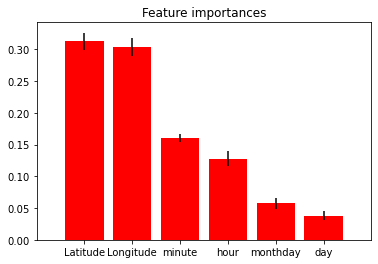

In [64]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns.tolist()[idx]  for idx in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

#### 5.2.2 Case 2 - Phase 2 - Model 2 (B) Random Forrest after Adding new variable - Holiday Data
I think also adding holiday and weather data will be very useful to our model. So I added holiday data as a flag and retrain Random Forest Classifier model. There is only one holiday in the given period of time which is Memorial Day(26th of May) .Result of both models are same but precision of predicting hailing a cab is increase 1%. Therefore we can use holiday flag for our model and it gives other data such as weather will be valuable.

In [65]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2008-01-01', end='2008-12-31').to_pydatetime()
print(holidays)

[datetime.datetime(2008, 1, 1, 0, 0) datetime.datetime(2008, 1, 21, 0, 0)
 datetime.datetime(2008, 2, 18, 0, 0) datetime.datetime(2008, 5, 26, 0, 0)
 datetime.datetime(2008, 7, 4, 0, 0) datetime.datetime(2008, 9, 1, 0, 0)
 datetime.datetime(2008, 10, 13, 0, 0)
 datetime.datetime(2008, 11, 11, 0, 0)
 datetime.datetime(2008, 11, 27, 0, 0)
 datetime.datetime(2008, 12, 25, 0, 0)]


In [66]:
data_new = data
data_new['Holiday_Flag'] = [(lambda x: (x in holidays) * 1)(x) for x in data_new['Timestamp']]

In [67]:
data_new.head(2)

Latitude  Longitude  Occupancy     Timestamp  day  hour  \
new_ictmuog_1     37.77    -122.45       1.00 1211018472.00 5.00 10.00   
new_ictmuog_2     37.77    -122.45       0.00 1211018474.00 5.00 10.00   

               minute  monthday  Holiday_Flag  
new_ictmuog_1    1.00     17.00             0  
new_ictmuog_2    1.00     17.00             0

In [68]:
X_new = data.drop(labels=['Occupancy', 'Timestamp'], axis=1)
X_new['Latitude'] = X_new['Latitude'] - lat_offset
X_new['Longitude'] = X_new['Longitude'] - long_offset

Y_new = data_new['Occupancy']

In [69]:
X_new_train, X_new_test, Y_new_train, Y_new_test = train_test_split(X_new, Y_new, stratify=Y, test_size=0.2, random_state=0)

In [70]:
baseline_acc_new = round(Y_new_test[Y_new_test == 0].shape[0] / Y_new_test.shape[0], 3)
print(f'The baseline accuracy of a naive model is {baseline_acc_new}')

The baseline accuracy of a naive model is 0.552


In [71]:
rf_holiday = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
rf_holiday.fit(X_new_train, Y_new_train)
Y_pred_new = rf_holiday.predict(X_new_test)
acc_new = round(accuracy_score(Y_new_test, Y_pred_new), 3)
print(f'The accuracy is {acc_new}')

The accuracy is 0.714


In [72]:
rf_holiday_results = ml_scores('rf_holiday', Y_new_test, Y_pred_new)
rf_holiday_results

Balanced Accuracy  Precision  Recall   F1  Kappa
rf_holiday               0.71       0.68    0.69 0.69   0.42

In [73]:
results_new = confusion_matrix(Y_new_test, Y_pred_new) 
print ('Confusion Matrix :')
print(results_new) 
print ('Accuracy Score :',accuracy_score(Y_new_test, Y_pred_new) )
print ('Report : ')
print (classification_report(Y_new_test, Y_pred_new) )

Confusion Matrix :
[[87189 32323]
 [29674 67309]]
Accuracy Score : 0.7136331093096838
Report : 
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74    119512
         1.0       0.68      0.69      0.68     96983

    accuracy                           0.71    216495
   macro avg       0.71      0.71      0.71    216495
weighted avg       0.71      0.71      0.71    216495



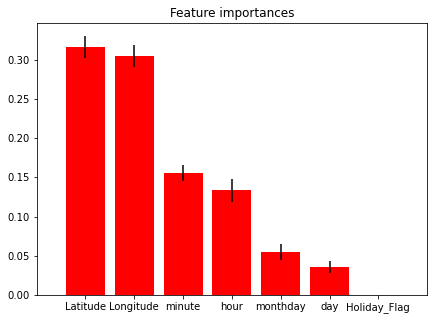

In [74]:
importances = rf_holiday.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_holiday.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(7,5))
plt.title("Feature importances")
plt.bar(range(X_new.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_new_train.shape[1]), [X_new_train.columns.tolist()[idx]  for idx in indices])
plt.xlim([-1, X_new_train.shape[1]])
plt.show()

#### 5.2.2.1 Case 2 - Phase 1 - Model Evaluation - RF on data without Holiday / RF on data with Holiday
I use accuracy as a metric, since the problem seems to be balanced (55% of the labels are 0 and 45% of the labels are 1). In a scenario with higher imbalance I could have used F1 score. So formulas and meanings for accuracy, F1 score, etc. below

Accuracy: The proportion of the total number of predictions that were correct.

Positive Predictive Value (Precision): The proportion of positive cases correctly identified.

Negative Predictive Value: The proportion of negative cases correctly identified.

Sensitivity (Recall): The proportion of actual positive cases correctly identified.

Specificity: The proportion of actual negative cases correctly identified.

F1 Score= (2 Precision Recall) / (Precision + Recall)

Kappa = (Observed Accuracy -Expected Accuracy) / (1 -Expected Accuracy)

In [75]:
modeling_performance = pd.concat([rf_results, rf_holiday_results])
modeling_performance.sort_values(by="F1", ascending=True)

Balanced Accuracy  Precision  Recall   F1  Kappa
rf                       0.71       0.67    0.70 0.68   0.42
rf_holiday               0.71       0.68    0.69 0.69   0.42

* Result of Holiday Flag added models has % increase in F1 score and precision of predicting hailing a cab is increased by 1%. Therefore, we can use holiday flag for our model for better prediction.
* Also, if we have other data like Weather Information, the predictions could be much better

## Hyperparameter Fine Tuning [ Not Ran ]

In [136]:
# f1 = make_scorer(f1_score)

In [137]:
# param_grid = {
#     'n_estimators': [200,500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [False, True],
#     'max_depth':[20,30]
# }

In [142]:
# clf_new = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
# rf_gs = GridSearchCV(estimator=clf_new, param_grid=param_grid
#       , scoring = f1, cv=5)

In [ ]:
# rf_gs.fit(X_new_train, Y_new_train)

## 5.3 Case 3 - Bonus Question - Clustering Taxi Cabs

I apply two different methods to identify cluster of taxi cabs.

First Approach:
* Using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) that is a popular unsupervised learning method utilized in model building and machine learning algorithms
    * I subset 10% of the total data and divided into two in terms of occupancy flag
    * I looked other cabs where they are driving in the past and where they will go after it
    * By doing so, I clustered its cabs together based on similarity of behavior

Second Approach
* Implementing RFM [Recency, Frequency, Monetary Value ] methodology
    * I subset 10% of the total data and I found total miles per cab, total occupied miles per cab and average active minutes per day
    * Using mindset of RFM, I split the data into 4 in terms of quantile
    * Using this quantiles, I create 7 sample of segments
    * I gave the definition of segments in the coding phase

## 5.3.1 DBSCAN

In [93]:
def visualize_dbscan(db: DBSCAN, X: DataFrame):

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            continue

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

Estimated number of clusters: 202


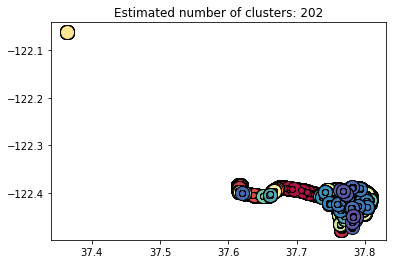

In [94]:
sampled_data = data[data['Occupancy'] == 1][['Latitude', 'Longitude']].sample(frac=0.3, random_state=0)

db = DBSCAN(eps=0.0005, min_samples=50)
db.fit(sampled_data)
visualize_dbscan(db=db, X=sampled_data)

Estimated number of clusters: 241


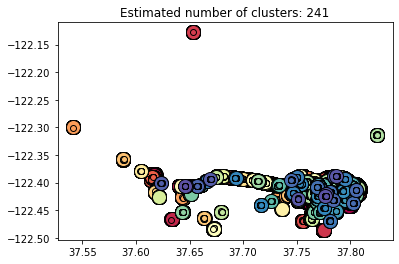

In [95]:
sampled_data = data[data['Occupancy'] == 0][['Latitude', 'Longitude']].sample(frac=0.3, random_state=0)

db = DBSCAN(eps=0.0005, min_samples=50)
db.fit(sampled_data)
visualize_dbscan(db=db, X=sampled_data)

## 5.3.2 Businesswise Segmentation (RFM Segmentation)

When I think the data that I have, total miles per cab, total occupied miles per cab and average active minutes per day variable are more important than others. I extract those data below and create new dataset for RFM mindset segmentation

In [7]:
def DateExtraction(row: Series):
    dt = datetime.datetime.fromtimestamp(row['Timestamp'])
    row['day'] = dt.weekday()
    row['hour'] = dt.hour
    row['minute'] = dt.minute
    row['monthday'] = dt.day
    return row

In [8]:
data = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    data = pd.concat([data, df])
data = data[['Latitude', 'Longitude', 'Occupancy', 'Taxi','Timestamp']]
data['day'] = 0
data['hour'] = 0
data['minute'] = 0
data['monthday'] = 0
data = data.apply(lambda row: DateExtraction(row), axis=1)
data.head()

Latitude  Longitude  Occupancy         Taxi   Timestamp  day  \
new_ictmuog_1  37.76981 -122.44865          1  new_ictmuog  1211018472    5   
new_ictmuog_2  37.76982 -122.44860          0  new_ictmuog  1211018474    5   
new_ictmuog_3  37.76985 -122.44846          0  new_ictmuog  1211018485    5   
new_ictmuog_4  37.77042 -122.44383          0  new_ictmuog  1211018542    5   
new_ictmuog_5  37.76965 -122.44238          0  new_ictmuog  1211018602    5   

               hour  minute  monthday  
new_ictmuog_1    10       1        17  
new_ictmuog_2    10       1        17  
new_ictmuog_3    10       1        17  
new_ictmuog_4    10       2        17  
new_ictmuog_5    10       3        17

In [9]:
Segment = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    Segment = pd.concat([Segment, df])

In [10]:
MileCover=pd.DataFrame()

MileCover = Segment.groupby(by=['Taxi'])['Miles'].sum()

print(MileCover)

Taxi
new_abniar      6210.321806
new_afpansh     5241.145742
new_agcowktu    6511.823500
new_aimidd      5526.623599
new_akyeerbi    5238.504253
new_asigno      6106.535672
new_aucjun      1362.857217
new_awribig     4193.499993
new_aygpha      3840.803662
new_ecfesy      5780.167259
new_ecjeody     5592.581941
new_ecnoplsi    5197.694264
new_ednillo     6478.721089
new_edrafs      1073.263297
new_eifvid      4726.839621
new_eincufpy     929.010719
new_ejshigib    6593.548105
new_ekyosjo     6622.093235
new_eoccoirv    6780.519187
new_eotcue         7.085391
new_epabcadu    7446.377622
new_equioc      7009.674127
new_etalrab     7944.022820
new_eybyay      6651.210295
new_eydadgio     733.936936
new_iblool      4600.625421
new_ictmuog     1487.910556
new_ifefrof     4388.483889
new_ijprukfr    5925.413146
new_imwrytsy    4849.110358
new_imwyojy     5357.361815
new_inckkiv     5935.119635
new_ioytgor     5146.912516
new_ishvirv     5837.211426
new_itacfl      6810.255451
new_oapwycti   

In [11]:
WPassangerDistance = Segment[Segment['Occupancy'] == 1]
#Distance With Passanger
DistanceWPassanger=pd.DataFrame()
DistanceWPassanger = WPassangerDistance.groupby(by=['Taxi'])['Miles'].sum()

In [12]:
RFMData = pd.merge(MileCover,DistanceWPassanger, on='Taxi', how='left')
print(RFMData)

                  Miles_x      Miles_y
Taxi                                  
new_abniar    6210.321806  3619.479695
new_afpansh   5241.145742  2761.237512
new_agcowktu  6511.823500  3593.224114
new_aimidd    5526.623599  3331.938898
new_akyeerbi  5238.504253  2679.182491
new_asigno    6106.535672  3305.215040
new_aucjun    1362.857217   787.504179
new_awribig   4193.499993  2397.563023
new_aygpha    3840.803662  2196.515044
new_ecfesy    5780.167259  3421.791134
new_ecjeody   5592.581941  3087.979879
new_ecnoplsi  5197.694264  3011.470380
new_ednillo   6478.721089  3597.348618
new_edrafs    1073.263297   590.953943
new_eifvid    4726.839621  2664.470635
new_eincufpy   929.010719   518.466737
new_ejshigib  6593.548105  3651.179953
new_ekyosjo   6622.093235  4032.696431
new_eoccoirv  6780.519187  3601.061951
new_eotcue       7.085391     3.642997
new_epabcadu  7446.377622  4587.744149
new_equioc    7009.674127  4057.480589
new_etalrab   7944.022820  4478.739403
new_eybyay    6651.210295

In [14]:
#Active Minutes
ActMin = pd.DataFrame()
ActMin = data.groupby(by=['Taxi'])['Timestamp'].count()
#Active Days
output  = pd.DataFrame()
output = data[['Taxi','monthday']]
output = output.drop_duplicates()
ActDay = pd.DataFrame()
ActDay = output.groupby(by=['Taxi'])['monthday'].count()

Active = pd.DataFrame()
Active = pd.merge(ActMin, ActDay, on='Taxi', how='left')
#Finding Active Minutes per Day
Active['ActMinPerDay'] = Active['Timestamp'] / Active['monthday']

In [26]:
Active.head()

Timestamp  monthday  ActMinPerDay
Taxi                                           
new_abniar        25525        24   1063.541667
new_afpansh       24357        24   1014.875000
new_agcowktu      21278        24    886.583333
new_aimidd        22632        24    943.000000
new_akyeerbi      20500        24    854.166667

In [15]:
RFMData = pd.merge(RFMData,Active, on='Taxi', how='left')
RFMDataF = RFMData[['Miles_x', 'Miles_y', 'ActMinPerDay']]
RFMDataF.rename(columns={'Miles_x': 'MileCoverage', 'Miles_y': 'MileCoverageWPassanger'}, inplace=True)
print(RFMDataF)

              MileCoverage  MileCoverageWPassanger  ActMinPerDay
Taxi                                                            
new_abniar     6210.321806             3619.479695   1063.541667
new_afpansh    5241.145742             2761.237512   1014.875000
new_agcowktu   6511.823500             3593.224114    886.583333
new_aimidd     5526.623599             3331.938898    943.000000
new_akyeerbi   5238.504253             2679.182491    854.166667
new_asigno     6106.535672             3305.215040   1135.583333
new_aucjun     1362.857217              787.504179    662.411765
new_awribig    4193.499993             2397.563023    847.409091
new_aygpha     3840.803662             2196.515044    862.818182
new_ecfesy     5780.167259             3421.791134   1071.708333
new_ecjeody    5592.581941             3087.979879    954.083333
new_ecnoplsi   5197.694264             3011.470380    978.875000
new_ednillo    6478.721089             3597.348618   1132.291667
new_edrafs     1073.26329

After merging data, I found the quantiles value. This will help me to divide my data into four in terms of every variable 

In [16]:
quantiles = RFMDataF.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
print(quantiles)

{'MileCoverage': {0.25: 4575.373400903842, 0.5: 5557.460681337283, 0.75: 6593.5481048966485}, 'MileCoverageWPassanger': {0.25: 2410.1842540233174, 0.5: 3087.9798790766504, 0.75: 3593.2241136802513}, 'ActMinPerDay': {0.25: 798.5833333333334, 0.5: 966.2083333333334, 0.75: 1063.5416666666667}}


In [17]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [18]:
RFMDataF['r_quartile'] = RFMDataF['MileCoverage'].apply(RScore, args=('MileCoverage',quantiles,))
RFMDataF['f_quartile'] = RFMDataF['MileCoverageWPassanger'].apply(FMScore, args=('MileCoverageWPassanger',quantiles,))
RFMDataF['m_quartile'] = RFMDataF['ActMinPerDay'].apply(FMScore, args=('ActMinPerDay',quantiles,))
RFMDataF.head()

MileCoverage  MileCoverageWPassanger  ActMinPerDay  r_quartile  \
Taxi                                                                           
new_abniar     6210.321806             3619.479695   1063.541667           3   
new_afpansh    5241.145742             2761.237512   1014.875000           2   
new_agcowktu   6511.823500             3593.224114    886.583333           3   
new_aimidd     5526.623599             3331.938898    943.000000           2   
new_akyeerbi   5238.504253             2679.182491    854.166667           2   

              f_quartile  m_quartile  
Taxi                                  
new_abniar             1           2  
new_afpansh            3           2  
new_agcowktu           2           3  
new_aimidd             2           3  
new_akyeerbi           3           3

In [19]:
RFMDataF['RFMScore'] = RFMDataF.r_quartile.map(str) + RFMDataF.f_quartile.map(str) + RFMDataF.m_quartile.map(str)
RFMDataF.head()

MileCoverage  MileCoverageWPassanger  ActMinPerDay  r_quartile  \
Taxi                                                                           
new_abniar     6210.321806             3619.479695   1063.541667           3   
new_afpansh    5241.145742             2761.237512   1014.875000           2   
new_agcowktu   6511.823500             3593.224114    886.583333           3   
new_aimidd     5526.623599             3331.938898    943.000000           2   
new_akyeerbi   5238.504253             2679.182491    854.166667           2   

              f_quartile  m_quartile RFMScore  
Taxi                                           
new_abniar             1           2      312  
new_afpansh            3           2      232  
new_agcowktu           2           3      323  
new_aimidd             2           3      223  
new_akyeerbi           3           3      233

In [20]:
RFMDataF.groupby(by=['RFMScore'])['RFMScore'].count()

RFMScore
131    1
142    1
143    3
144    9
221    1
223    2
232    4
233    3
234    2
244    1
311    2
312    1
321    3
322    1
323    2
324    1
332    1
333    1
334    1
411    5
412    3
413    2
421    1
422    2
Name: RFMScore, dtype: int64

### So we can give clusters a name accordingly. Here is some example of it.

* Best Taxi Drivers: Actively driving cab and working much more than other per day
    * (if mile coverage, mile coverage with passenger and active minutes per day are in the top %25)


* Globetrotter : Actively driving cab
    * (if mile coverage is in the top %25)


* Most Occupied Taxi : Actively driving cab with passenger
    * (if mile coverage with passenger is in the top %25)


* Most Active Taxi: Working much more than other per day
    * (if active minutes per day is in the top %25)


* Fast and Vacant: Actively driving more miles but less minutes per day. That means he/she drives fast with more vacant
    * (if mile coverage is in the top %25 and mile coverage with passenger and active minutes per day are in the bottom %25)


* Lucky Stand-by: Driver is not driving without passenger, but he/she drive more than other in terms of mile coverage with passenger and active minutes per day.
    * (if mile coverage is in the bottom %25 and mile coverage with passenger and active minutes per day are in the top %25)


* Not Active Taxi Drivers: Not actively driving cab and working much more than other per day
    * (if mile coverage, mile coverage with passenger and active minutes per day are in the bottom %25)

In [22]:
print("Best Taxi Drivers: ",len(RFMDataF[RFMDataF['RFMScore']=='444']))
print('Globetrotter : ',len(RFMDataF[RFMDataF['r_quartile']==4]))
print('Most Occupied Taxi : ',len(RFMDataF[RFMDataF['f_quartile']==4]))
print("Most Active Taxi: ",len(RFMDataF[RFMDataF['m_quartile']==4]))
print('Fast and Vacant: ', len(RFMDataF[RFMDataF['RFMScore']=='411']))
print('Lucky Stand-by: ',len(RFMDataF[RFMDataF['RFMScore']=='144']))
print('Not Active Taxi Drivers: ',len(RFMDataF[RFMDataF['RFMScore']=='111']))

Best Taxi Drivers:  0
Globetrotter :  13
Most Occupied Taxi :  14
Most Active Taxi:  14
Fast and Vacant:  5
Lucky Stand-by:  9
Not Active Taxi Drivers:  0


# 6. Depolyment Strategy
* Model artifacts like the Encoders, Scalers and Model Object to be saved
* Complete pipeline to be deployed with separate containers for each steps like data collection, preparation, feature engineering, Model Training, Prediction, Monitoring and Retraining
* Jobs to be scheduled using ML Flow or Airflow


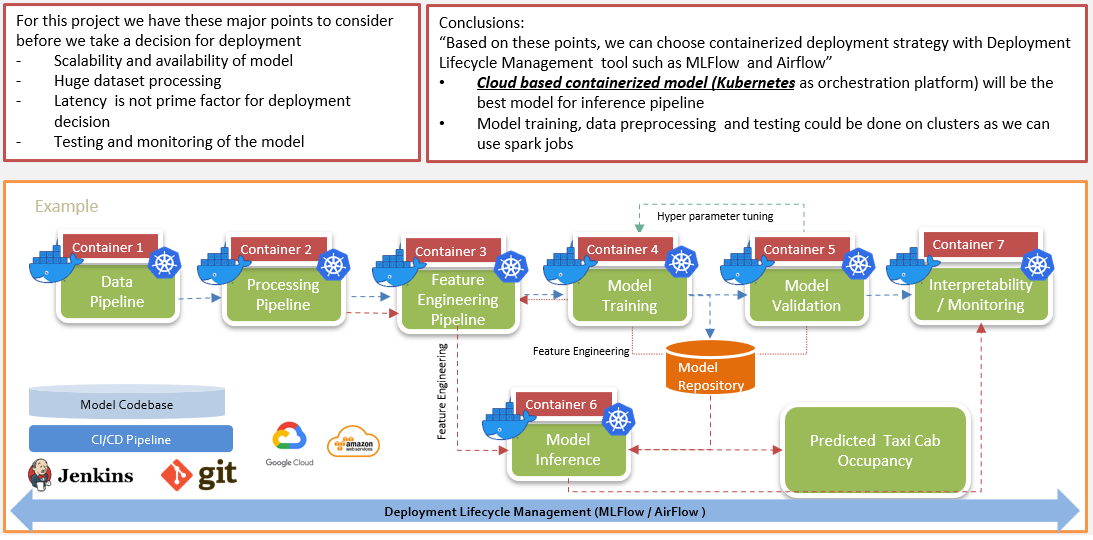